# CLINT WP5: DEBUG: why do all the maps of soil moisture have only one color?

### 2023/09/20

# CLINT WP5: DEBUG: why do soil moisture graphs have two lines?

### 2023/09/28

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
import seaborn as sns
#from mpl_toolkits import Basemap
import CLINT001_functions as clint
importlib.reload(clint)

<module 'CLINT001_functions' from '/users_home/csp/as18623/CLINT001_functions.py'>

In [6]:
## DIRECTORIES
machine = 'juno'

if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/squintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/antonellosquintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'juno':
    modeldir = '/data/csp/as18623/ERA5/'
    obsdir = '/data/csp/as18623/CLINT_obs/'
    workmetadir = '/work/csp/as18623/CLINT_metadata/'
    metadatadir = '/data/csp/as18623/CLINT_metadata/'
    maskdir = '/data/csp/as18623/CLINT_metadata/Masks/Test3_Clusters/'
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/'

In [7]:
## Open land-sea mask and round to integer
## The mask has values between 0 and 1 according to the proportion of the grid-point
##  which is covered by land
## Any gridpoint with more than 0.5 is rounded to 1 and considered land

lsm = xr.open_dataset(f'{modeldir}/era5_lsm.nc').round()

In [8]:
### Read series of tmax and HWMI related to Lake Como
lchw = pd.read_csv('LakeComo_tmax_HW.csv',index_col='date')

In [9]:
### Identify 2019 heat wave

row_maxHWMI = lchw.loc[lchw['Valle_HWintensity'].idxmax()]
date2019_dt = dt.strptime(row_maxHWMI.name,"%Y-%m-%d")
date2019_ts = pd.to_datetime(date2019_dt)

In [10]:
### Identify dates
date_aux_dt = dt.strptime(lchw.loc[lchw.year==1983]['Valle_HWintensity'].idxmax(),"%Y-%m-%d")
date_aux_ts = pd.to_datetime(date_aux_dt)

In [11]:
date_aux_ts

Timestamp('1983-07-21 00:00:00')

In [12]:
## indicate the date of the events and the variables to be included

dates_ts = (pd.to_datetime("2022-07-22"), 
            pd.to_datetime("2019-06-27"), 
            pd.to_datetime("2003-08-11"), 
            pd.to_datetime("1983-07-21"))


variables = ['tmax','mslp','sm']

In [54]:
date_ts = pd.to_datetime("2003-08-11")
var = 'tmax'

In [55]:
importlib.reload(clint)
drivers = pd.read_csv(f'{workmetadir}drivers.csv')

### From function 
### clint.loop_map_grids(drivers, dates_ts, variables, lsm, modeldir, maskdir, plotdir)

In [56]:
y = date_ts.year
drivers_sub = drivers.loc[drivers['var'] == var]
anom_xr = xr.open_dataset(f'{modeldir}/era5_{var}_dailyanom_{y}_cropped.nc')
if var == 'mslp':
    anom_xr['msl'] = anom_xr['msl']/100
    

In [64]:
drivers_row = drivers_sub.iloc[0]
ncvar = drivers_row['nc_var']

In [66]:
mask_df = pd.read_csv(f"{maskdir}{drivers_row['clmask_test3']}",index_col=[0])
cl_nr = drivers_row['cl_nr']
submask = mask_df[mask_df.cluster == cl_nr]
maskedanom = clint.mask_xr_w_df(var, anom_xr, submask, lsm)

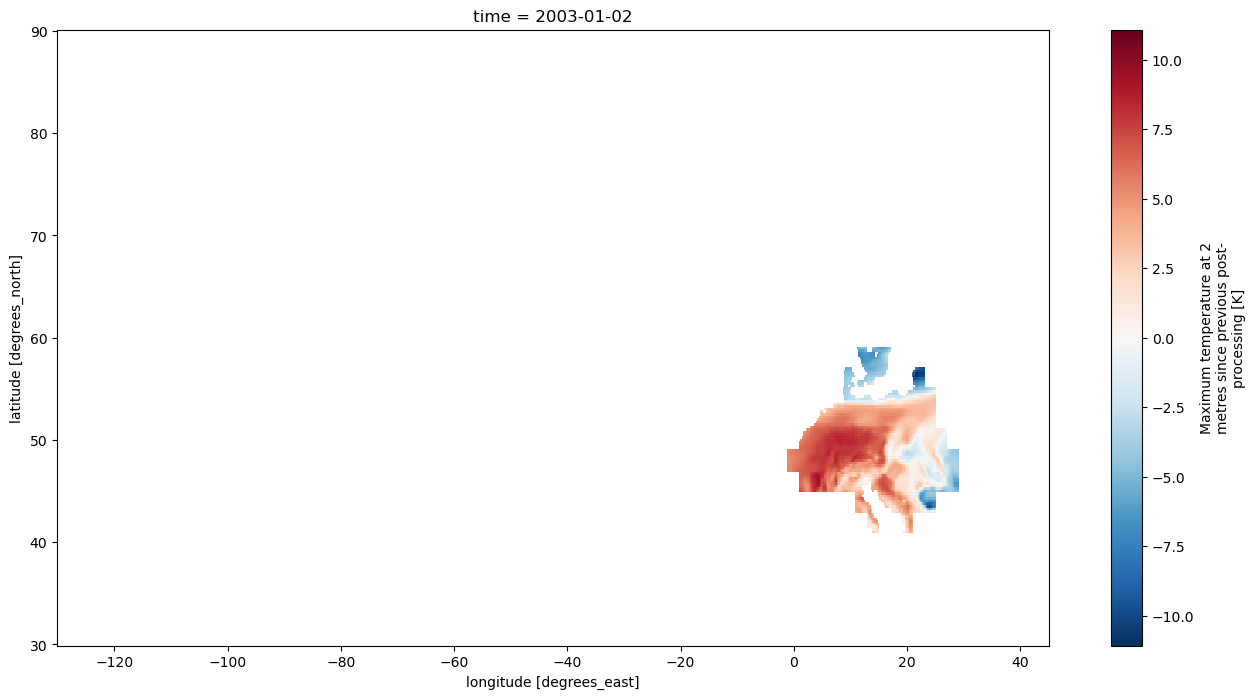

In [68]:
maskedanom.isel(time=1)[ncvar].plot()

### From function 
### clint.multimaps_lag (xrdf, targetdate_ts, drivers_row, plotdir, proj='Ortographic', vmin='drivers', vmax='drivers')

In [69]:
xrdf = maskedanom
targetdate_ts = date_ts
proj = 'Ortographic'
vmin='drivers'
vmax='drivers'

In [70]:
minlag = int(drivers_row['minlag'])
maxlag = int(drivers_row['maxlag'])
fig_width = drivers_row['fig_width']
if np.isnan(fig_width):
    fig_width = 48

ax_width = drivers_row['ax_width']
if np.isnan(ax_width):
    ax_width = 12

ax_height = drivers_row['ax_height']
if np.isnan(ax_height):
    ax_height = 8

text_plot_lon = drivers_row['text_plot_lon']
if np.isnan(text_plot_lon):
    text_plot_lon = drivers_row['cl_ext_E']-2

text_plot_lat = drivers_row['text_plot_lat']
if np.isnan(text_plot_lat):
    text_plot_lat = drivers_row['cl_ext_N']-2

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')

y = targetdate_ts.year
m = str(targetdate_ts.month).zfill(2)
d = str(targetdate_ts.day).zfill(2)


var = drivers_row['var']
# Determine extremes of the date range considered, in the netcdf every day has 12:00 as hour
mintime_ts = targetdate_ts - pd.DateOffset(days = maxlag) + pd.DateOffset(hours = 12)
maxtime_ts = targetdate_ts - pd.DateOffset(days = minlag) + pd.DateOffset(hours = 12)

mintime_str = dt.strftime(mintime_ts,'%Y-%m-%d')
maxtime_str = dt.strftime(mintime_ts,'%Y-%m-%d')

numfigs = len(range(minlag,maxlag+1))
numfigs_h = np.floor(fig_width/ax_width)
numfigs_v = np.ceil(numfigs/numfigs_h)

In [73]:


# geo_axes = plt.subplot(int(numfigs_v), int(numfigs_h), f+1,
#                        projection=ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'],
#                                                     central_latitude=drivers_row['cl_ortho_lat']))

# sub1d[nc_var].plot(ax=geo_axes,transform=ccrs.PlateCarree(),cmap='PRGn', 
#                    vmin = vmin, vmax = vmax)


Text(0.5, 1.0, '')

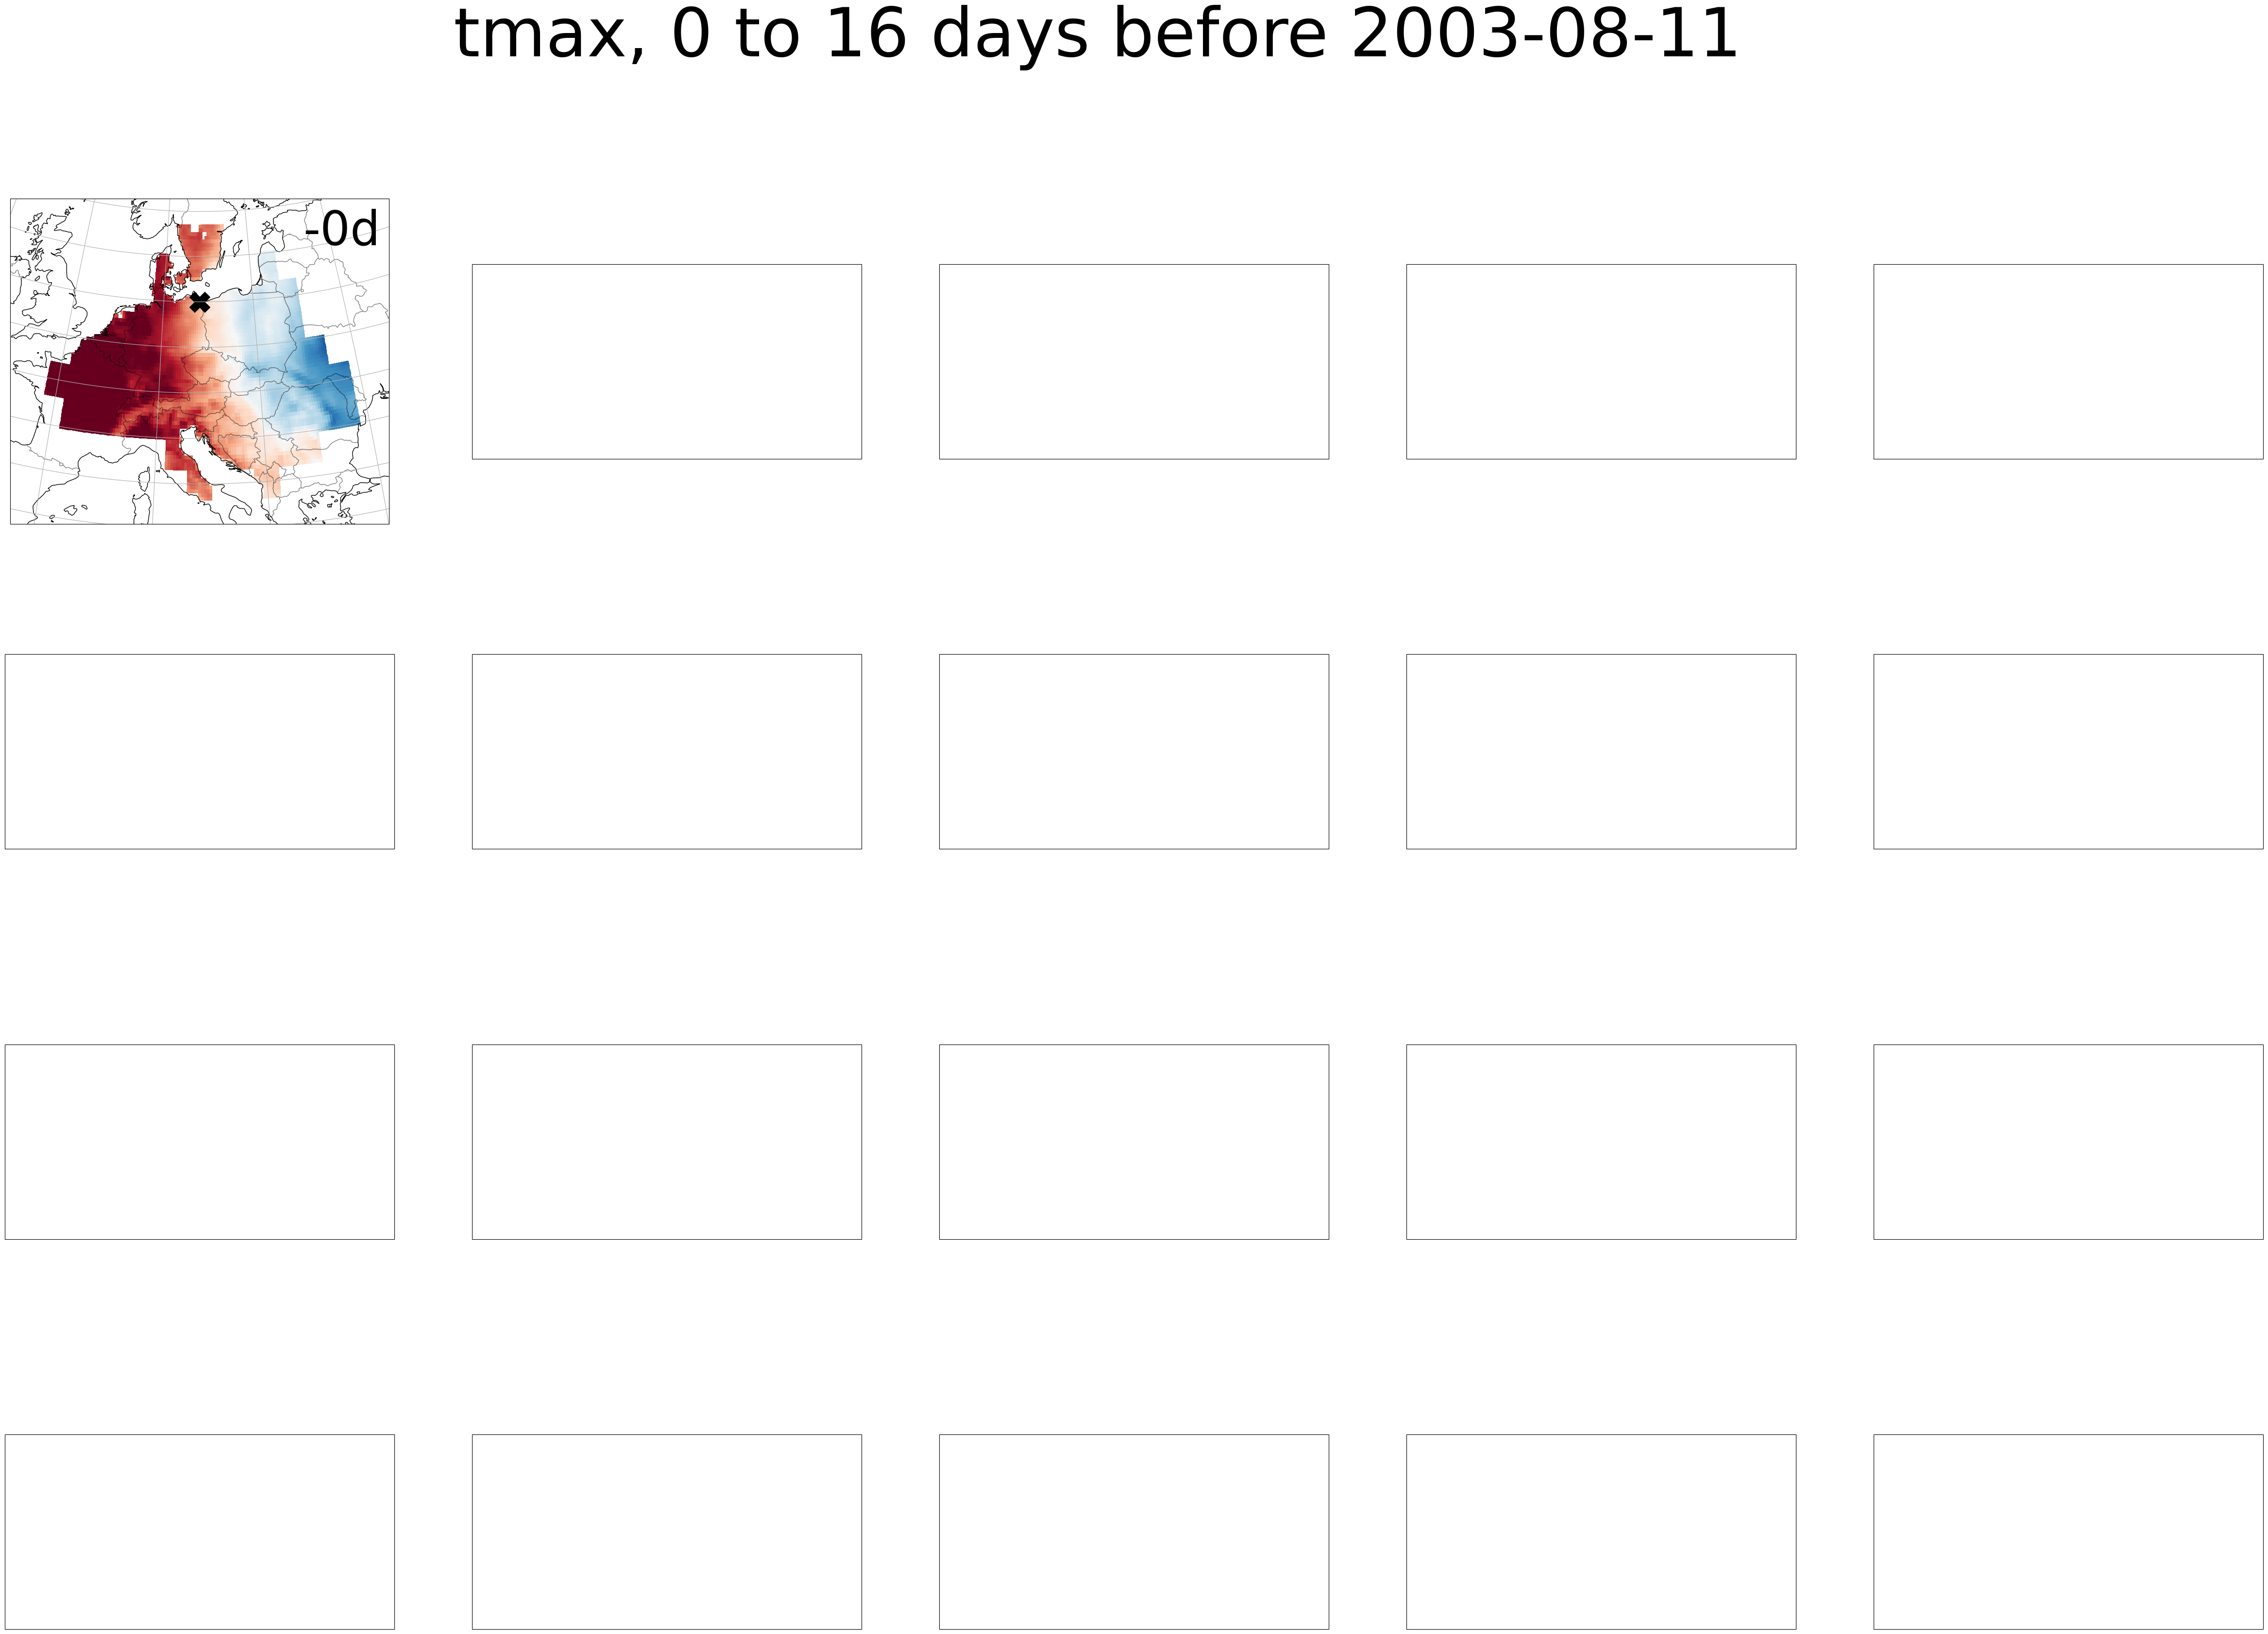

In [74]:
cl_name = drivers_row['cluster']
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(int(numfigs_v), int(numfigs_h),
                        subplot_kw={'projection': proj},
                        figsize=(fig_width,int(numfigs_v*ax_height)),
                        sharey=True,sharex=True)#,
                        #layout="constrained")
fig.suptitle(f'{var}, {minlag} to {maxlag} days before {targetdate_str}', fontsize = 100)
axs = axs.flatten()

lag=minlag
f=0

if vmin == 'drivers':
    vmin = drivers_row['vmin']
if vmax == 'drivers':
    vmax = drivers_row['vmax']
var = drivers_row['var']
nc_var = drivers_row.nc_var

if var == 'tmax':
    palette = plt.cm.RdBu_r
if var == 'mslp':
    palette = plt.cm.PRGn_r
if var == 'sm':
    palette = plt.cm.BrBG

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')


plotdate_ts = targetdate_ts - pd.DateOffset(days = lag)# + pd.DateOffset(hours = 12)
sub1d = xrdf.sel(time=plotdate_ts)
axs[f].remove()
geo_axes = plt.subplot(int(numfigs_v), int(numfigs_h), f+1,
                       projection=ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'],
                                                    central_latitude=drivers_row['cl_ortho_lat']))

cs=sub1d[nc_var].plot(ax=geo_axes,transform=ccrs.PlateCarree(),cmap=palette, 
                   vmin = vmin, vmax = vmax,add_colorbar=False)
geo_axes.set_extent(drivers_row[['cl_ext_W','cl_ext_E','cl_ext_S','cl_ext_N']])    
geo_axes.scatter(x=drivers_row['cluster_centre_lon'], y=drivers_row['cluster_centre_lat'],
            marker='X',color='black',s=900,transform=ccrs.PlateCarree(),alpha=1)
geo_axes.coastlines()
geo_axes.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
#geo_axes.text(x=text_plot_lon, y=text_plot_lat, 
#              s=f'-{lag}d', transform=ccrs.PlateCarree(), fontsize=70)
geo_axes.text(x=0.875, y=0.9, horizontalalignment='center', verticalalignment='center',
              s=f'-{lag}d', transform=geo_axes.transAxes, fontsize=70)

geo_axes.gridlines()
plt.title(None)


# From function daily_series_w_lags(xrdf, drivers_row, targetdate_ts, what, plotdir)

In [75]:
what = 'quantiles'

In [76]:
y = targetdate_ts.year
m = str(targetdate_ts.month).zfill(2)
d = str(targetdate_ts.day).zfill(2)

vmin = drivers_row['vmin']
vmax = drivers_row['vmax']

if what == 'centroid':
    cc_lon = drivers_row['cluster_centre_lon']
    cc_lat = drivers_row['cluster_centre_lat']
    cc_ser = xrdf.sel(longitude = cc_lon, latitude = cc_lat)        
if what == 'average':
    cc_ser = xrdf.mean(dim=['longitude','latitude'])#average on the whole domain
if what == 'quantiles':        
    cc_ser75 = xrdf.quantile(q=0.75, dim=['longitude','latitude'])#average on the whole domain
    cc_ser10 = xrdf.quantile(q=0.10, dim=['longitude','latitude'])#average on the whole domain
    cc_ser25 = xrdf.quantile(q=0.25, dim=['longitude','latitude'])#average on the whole domain
    cc_ser50 = xrdf.quantile(q=0.50, dim=['longitude','latitude'])#average on the whole domain
    cc_ser90 = xrdf.quantile(q=0.90, dim=['longitude','latitude'])#average on the whole domain




var = drivers_row['var']
ncvar = drivers_row['nc_var']
cl_name = drivers_row['cluster']

minlag = int(drivers_row['minlag'])
maxlag = int(drivers_row['maxlag'])
# Determine extremes of the date range considered
mintime_ts = targetdate_ts - pd.DateOffset(days = maxlag)# + pd.DateOffset(hours = 12)
maxtime_ts = targetdate_ts - pd.DateOffset(days = minlag)# + pd.DateOffset(hours = 12)


(-10.0, 10.0)

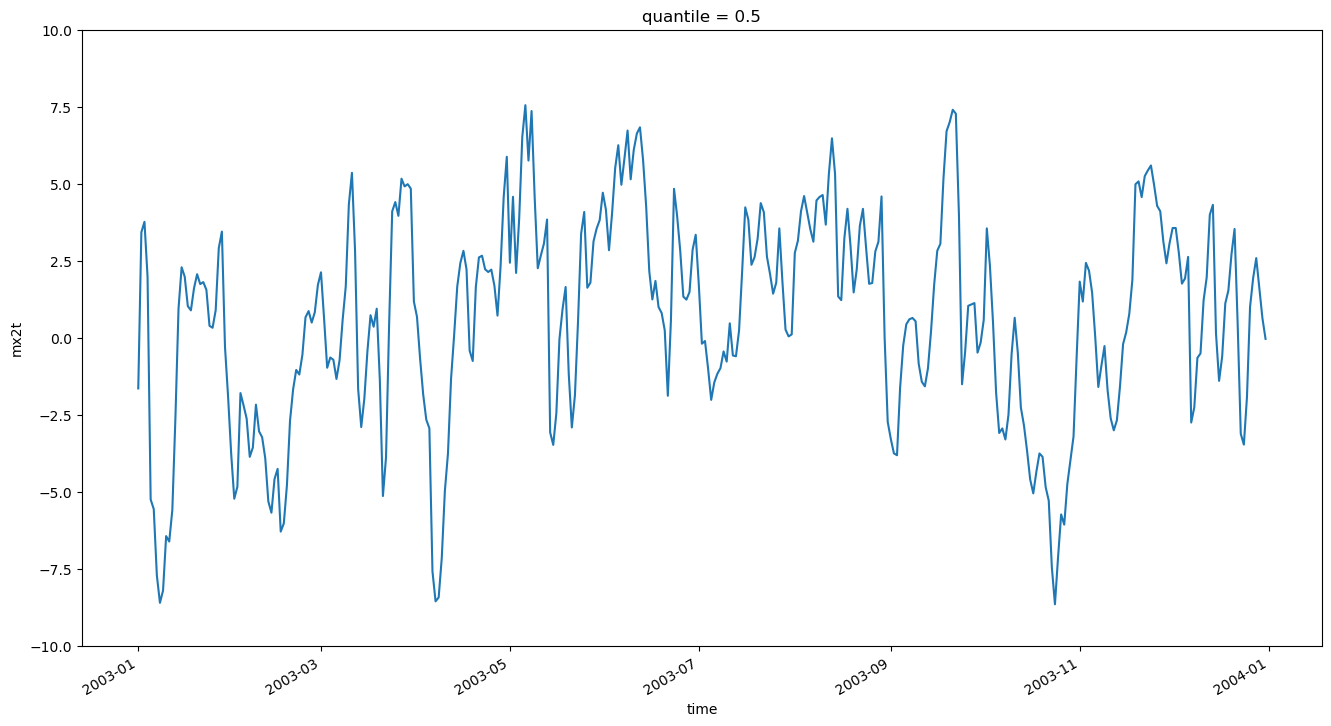

In [78]:
fig,ax = plt.subplots()
cc_ser50[ncvar].plot()
ax.set_ylim(vmin,vmax)

In [102]:
what = 'centroid'
if what == 'centroid':
    cc_lon = drivers_row['cluster_centre_lon']
    cc_lat = drivers_row['cluster_centre_lat']
    cc_ser = xrdf.sel(longitude = 10, latitude = 46)        

In [106]:
lsm.sel(longitude = cc_lon, latitude = cc_lat-0.25)

<xarray.Dataset>
Dimensions:    (time: 1)
Coordinates:
    longitude  float32 14.0
    latitude   float32 53.75
  * time       (time) datetime64[ns] 2022-01-01
Data variables:
    lsm        (time) float32 1.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-19 16:38:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

<Figure size 1600x800 with 0 Axes>

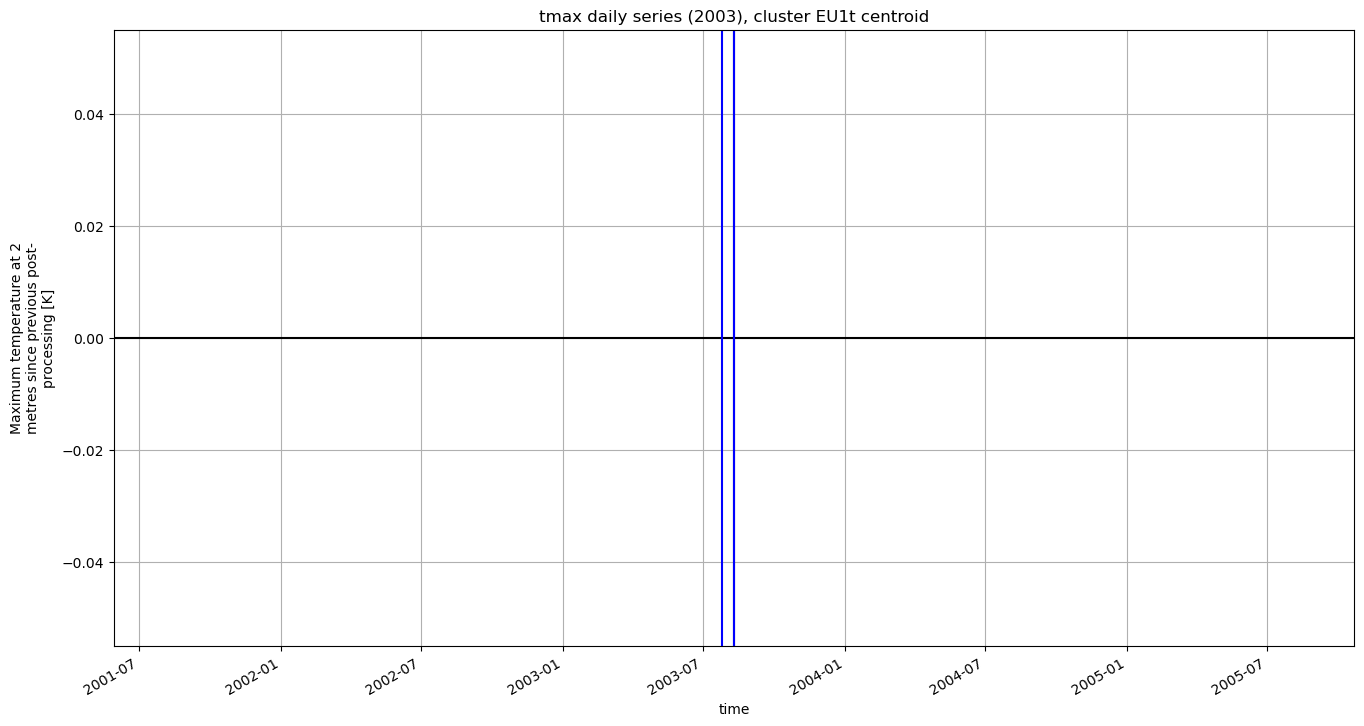

In [79]:
plt.rcParams['figure.figsize'] = [16,8]
plt.figure()
fig,ax = plt.subplots()
if what == 'centroid':
    cc_ser[ncvar].plot(color='red')
if what == 'average':
    cc_ser[ncvar].plot(color='sienna')
if what == 'quantiles':
    cc_ser10[ncvar].plot(color='pink',linewidth='2',linestyle='dotted')
    cc_ser25[ncvar].plot(color='deeppink',linewidth='3',linestyle='dashed')
    #cc_ser50[ncvar].plot(color='mediumvioletred',linewidth='4')
    #cc_ser75[ncvar].plot(color='deeppink',linewidth='3',linestyle='dashed')
    #cc_ser90[ncvar].plot(color='pink',linewidth='2',linestyle='dotted')


#ax.set_ylim(vmin,vmax)   
plt.title(f'{var} daily series ({y}), cluster {cl_name} {what}')
plt.axhline(y=0, color='k')
plt.axvline(x = targetdate_ts, color = 'k', label = 'axvline - full height')
plt.axvline(x = mintime_ts, color = 'b', label = 'axvline - full height')
plt.axvline(x = maxtime_ts, color = 'b', label = 'axvline - full height')
plt.grid()
plt.savefig(f"{plotdir}CLINT050_{y}{m}{d}case_{var}_{cl_name}_{what}.png", facecolor='w')
plt.show()  

<Figure size 1600x800 with 0 Axes>

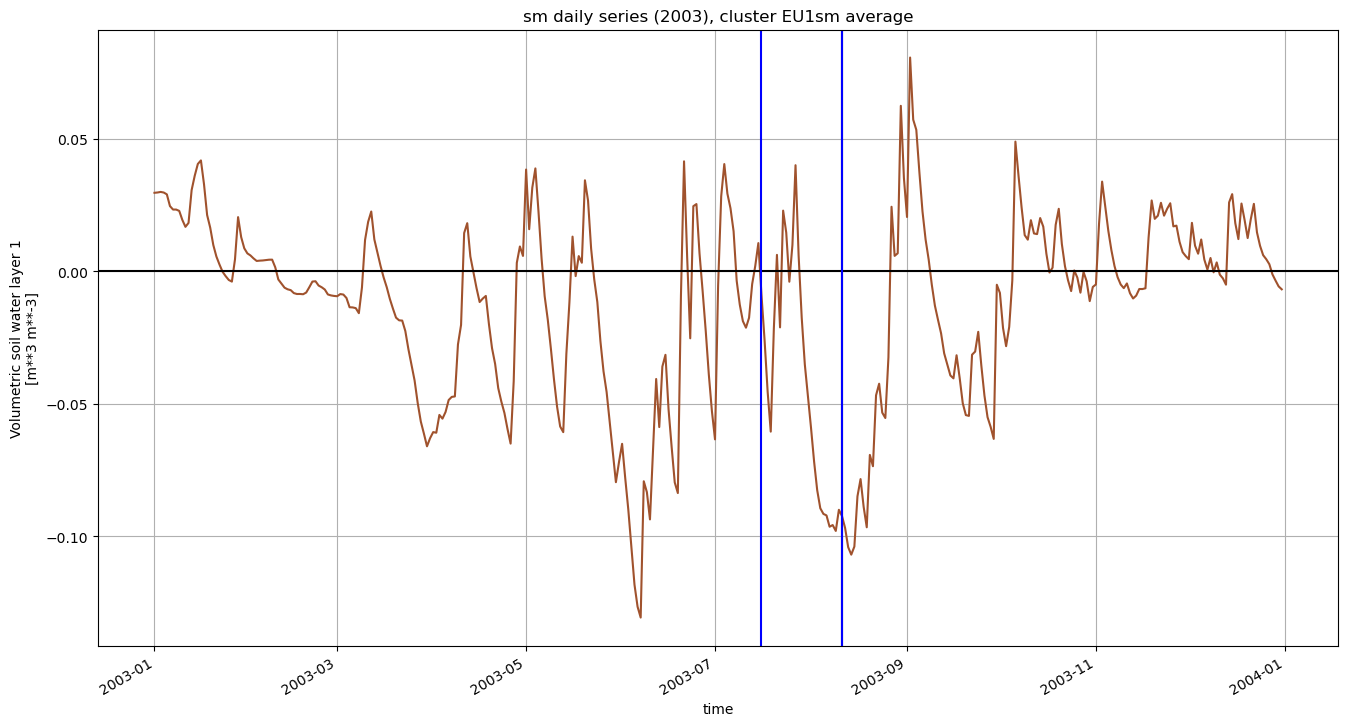

In [53]:
what = 'average'
if what == 'centroid':
    cc_lon = drivers_row['cluster_centre_lon']
    cc_lat = drivers_row['cluster_centre_lat']
    cc_ser = xrdf.sel(longitude = cc_lon, latitude = cc_lat)        

plt.rcParams['figure.figsize'] = [16,8]
plt.figure()
fig,ax = plt.subplots()
if what == 'centroid':
    cc_ser[ncvar].plot(color='red')
if what == 'average':
    cc_ser[ncvar].plot(color='sienna')
if what == 'quantiles':
    cc_ser10[ncvar].plot(color='pink',linewidth='2',linestyle='dotted')
    cc_ser25[ncvar].plot(color='deeppink',linewidth='3',linestyle='dashed')
    #cc_ser50[ncvar].plot(color='mediumvioletred',linewidth='4')
    #cc_ser75[ncvar].plot(color='deeppink',linewidth='3',linestyle='dashed')
    #cc_ser90[ncvar].plot(color='pink',linewidth='2',linestyle='dotted')


#ax.set_ylim(vmin,vmax)   
plt.title(f'{var} daily series ({y}), cluster {cl_name} {what}')
plt.axhline(y=0, color='k')
plt.axvline(x = targetdate_ts, color = 'k', label = 'axvline - full height')
plt.axvline(x = mintime_ts, color = 'b', label = 'axvline - full height')
plt.axvline(x = maxtime_ts, color = 'b', label = 'axvline - full height')
plt.grid()
plt.savefig(f"{plotdir}CLINT050_{y}{m}{d}case_{var}_{cl_name}_{what}.png", facecolor='w')
plt.show()  


<Figure size 1600x800 with 0 Axes>

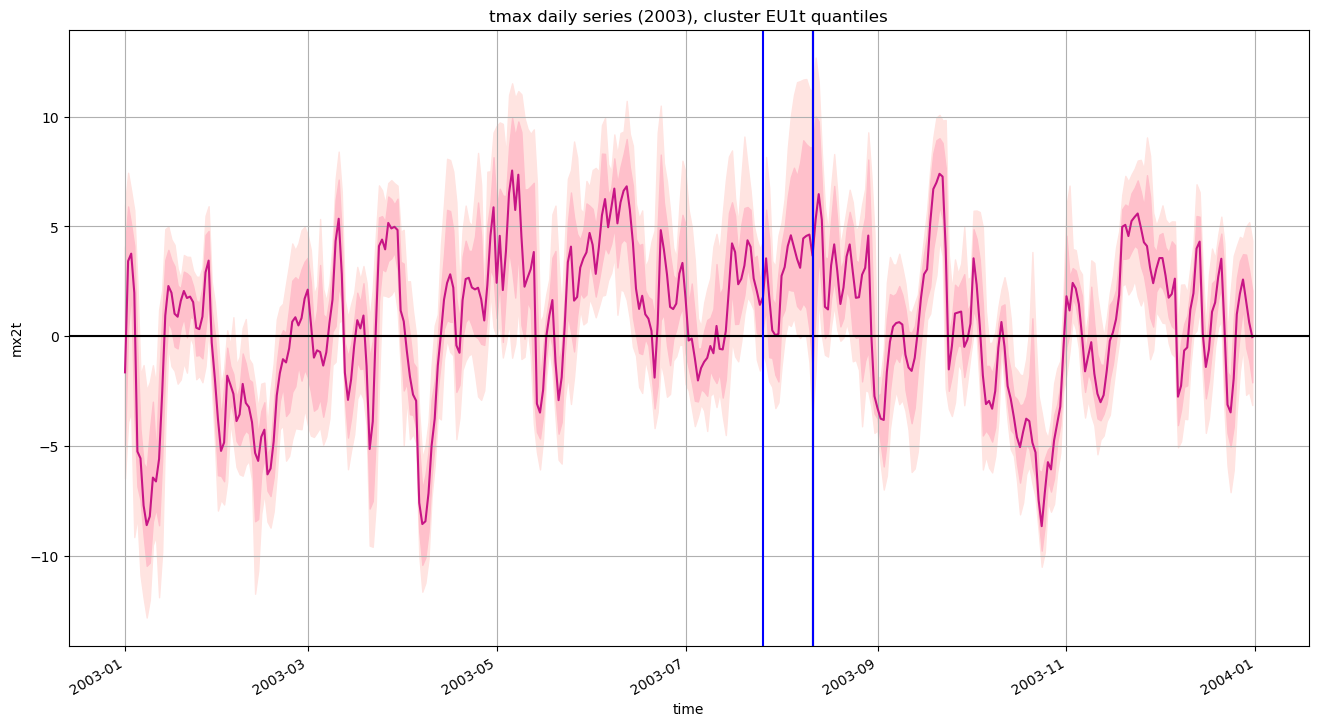

In [112]:
what = 'quantiles'


plt.rcParams['figure.figsize'] = [16,8]
plt.figure()
fig,ax = plt.subplots()
if what == 'centroid':
    cc_ser[ncvar].plot(color='red')
if what == 'average':
    cc_ser[ncvar].plot(color='sienna')
if what == 'quantiles':
    ax.fill_between(x=cc_ser['time'],y1=cc_ser10[ncvar],y2=cc_ser90[ncvar],color='mistyrose')
    ax.fill_between(x=cc_ser['time'],y1=cc_ser25[ncvar],y2=cc_ser75[ncvar],color='pink')
    cc_ser50[ncvar].plot(color='mediumvioletred')


#ax.set_ylim(vmin,vmax)   
plt.title(f'{var} daily series ({y}), cluster {cl_name} {what}')
plt.axhline(y=0, color='k')
plt.axvline(x = targetdate_ts, color = 'k', label = 'axvline - full height')
plt.axvline(x = mintime_ts, color = 'b', label = 'axvline - full height')
plt.axvline(x = maxtime_ts, color = 'b', label = 'axvline - full height')
plt.grid()
plt.savefig(f"{plotdir}CLINT050_{y}{m}{d}case_{var}_{cl_name}_{what}.png", facecolor='w')
plt.show()  


In [57]:
drivers_row

var                                      sm
nc_var                                swvl1
test_nr                                   3
cluster                               EU1sm
cluster_info                 Eastern Europe
minlag                                    0
maxlag                                   26
cluster_centre_lon                     24.0
cluster_centre_lat                     56.0
cl_ortho_lon                           30.0
cl_ortho_lat                           54.0
cl_ext_W                               14.0
cl_ext_E                               46.0
cl_ext_S                               46.0
cl_ext_N                               62.0
text_plot_lon                           NaN
text_plot_lat                           NaN
fig_width                              60.0
ax_width                               15.0
ax_height                              12.0
clmask_test3          labels3sm1Europe5.csv
cl_nr                                     1
vmin                            

In [56]:
vmax

nan

In [52]:
np.nanmedian(sub1d[nc_var])

-0.0013149722

In [ ]:
for f,lag in enumerate(range(minlag,maxlag+1)):

    if vmin == 'drivers':
        vmin = drivers_row['vmin']
    if vmax == 'drivers':
        vmax = drivers_row['vmax']
    var = drivers_row['var']
    nc_var = drivers_row.nc_var

    if var == 'tmax':
        palette = plt.cm.RdBu_r
    if var == 'mslp':
        palette = plt.cm.PRGn_r
    if var == 'sm':
        palette = plt.cm.BrBG

    targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')


    plotdate_ts = targetdate_ts - pd.DateOffset(days = lag)# + pd.DateOffset(hours = 12)
    sub1d = xrdf.sel(time=plotdate_ts)
    axs[f].remove()
    geo_axes = plt.subplot(int(numfigs_v), int(numfigs_h), f+1,
                           projection=ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'],
                                                        central_latitude=drivers_row['cl_ortho_lat']))

    cs=sub1d[nc_var].plot(ax=geo_axes,transform=ccrs.PlateCarree(),cmap=palette, 
                       vmin = vmin, vmax = vmax,add_colorbar=False)
    geo_axes.set_extent(drivers_row[['cl_ext_W','cl_ext_E','cl_ext_S','cl_ext_N']])    
    geo_axes.scatter(x=drivers_row['cluster_centre_lon'], y=drivers_row['cluster_centre_lat'],
                marker='X',color='black',s=900,transform=ccrs.PlateCarree(),alpha=1)
    geo_axes.coastlines()
    geo_axes.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    #geo_axes.text(x=text_plot_lon, y=text_plot_lat, 
    #              s=f'-{lag}d', transform=ccrs.PlateCarree(), fontsize=70)
    geo_axes.text(x=0.875, y=0.9, horizontalalignment='center', verticalalignment='center',
                  s=f'-{lag}d', transform=geo_axes.transAxes, fontsize=70)

    geo_axes.gridlines()
    plt.title(None)
    #plt.title(f'-{lag}d', fontsize = 50)
    #geo_axes._legend.remove()
#handles, labels = geo_axes.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
for f in range(numfigs,int(numfigs_h*numfigs_v)):
    #print(f)
    fig.delaxes(axs[int(f)])  

fig.subplots_adjust(bottom=0.04+1/(numfigs_v*ax_height), top=0.94, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

cbar_ax = fig.add_axes([0.07, 0.03, 0.86,1/(numfigs_v*ax_height)])

cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=50)